## <center>Predicting Diabetes in ICU Patients:<br> Women in Data Science 2021 Competition

### Background

The goal for the [2021 WIDS competition](https://www.kaggle.com/c/widsdatathon2021) is to predict whether a patient admitted into the ICU has diabetes. The submission is evaluated using Area under the Receiver Operating Characteristic (ROC) curve between the predicted and the observed target (diabetes_mellitus_diagnosis).

This was my first-ever Kaggle competition and my team achieved 87th place in the final leaderboard, top 10% of all the teams. Not too bad for a first Kaggle competition! 

In our final competition submission, we incorporated some features generated by a previous Kaggle notebook, used light gradient boost machine (lightGBM) to train the model, bayesian optimization for hyperparameter tuning, and implemented pseudo-labeling in hope to further increase the accuracy of the model. 

In [73]:
# import libraries
from scipy.stats import kurtosis, iqr, skew, gmean, hmean, mode, normaltest, shapiro, ks_2samp
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy import stats
import os, gc, sys, time, random, math
from matplotlib import pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

In [74]:
# Load the dataset
train_data = pd.read_csv('../data/widsdatathon2021/TrainingWiDS2021.csv', index_col=[0])
test_data = pd.read_csv('../data/widsdatathon2021/UnlabeledWiDS2021.csv', index_col=[0])
dataDict = pd.read_csv('../data/widsdatathon2021/DataDictionaryWiDS2021.csv')

test_id = test_data.encounter_id.values

In [75]:
train_Y = train_data.diabetes_mellitus
del train_data['diabetes_mellitus']

Train and test data have 130157 and 10234 rows respectively. There are 180 features.

### Exploratory Data Analysis

#### Data visualization

<AxesSubplot:xlabel='diabetes_mellitus', ylabel='count'>

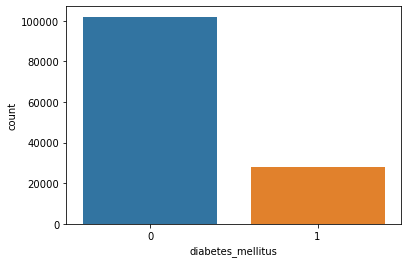

In [60]:
# Plot class labels
sns.countplot('diabetes_mellitus',data=train_data)

There are about five times as many class 0 labels in the training set as class 1 labels.

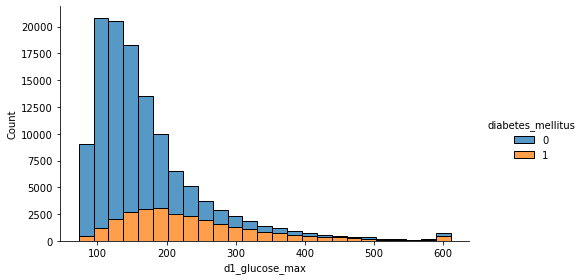

In [62]:
sns.displot(data = train_data, kind = 'hist', 
            x = 'd1_glucose_max', hue = 'diabetes_mellitus', 
            multiple = 'stack',bins=25, height = 4, aspect = 1.7)

The higher the glucose_max the higher precentage of patients with diabetes (especially >250 range). There are also outliers for d1_glucose_max measure.

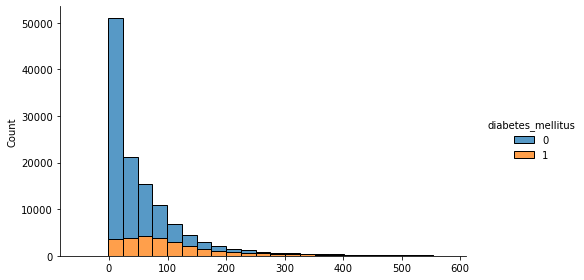

In [64]:
sns.displot(data = train_data, kind = 'hist', 
            x = train_data.d1_glucose_max - train_data.d1_glucose_min, hue = 'diabetes_mellitus', 
            multiple = 'stack',bins=25, height = 4, aspect = 1.7)

Following the discovery above, the greater the range of d1_glucose (d1_glucose_max - d1_glucose_min), the larger amount of individuals with diabetes. 

In [78]:
# Features belonging to demographic:
demo_fea = dataDict.loc[dataDict['Category'] == 'demographic', 'Variable Name'].values
demo_fea = np.delete(demo_fea, np.argwhere(demo_fea == 'icu_admit_type'))
# Features belonging to Apache covariate:
ApaVar_fea = dataDict.loc[dataDict['Category'] == 'APACHE covariate', 'Variable Name'].values
# Features belonging to vitals:
vital_fea = dataDict.loc[dataDict['Category'] == 'vitals', 'Variable Name'].values
# Features belonging to labs:
labs_fea = dataDict.loc[dataDict['Category'] == 'labs', 'Variable Name'].values
# Features belonging to labs blood gas:
lbg_fea = dataDict.loc[dataDict['Category'] == 'labs blood gas', 'Variable Name'].values
# Features belonging to Apache comorbidity:
ApaMor_fea = dataDict.loc[dataDict['Category'] == 'APACHE comorbidity', 'Variable Name'].values

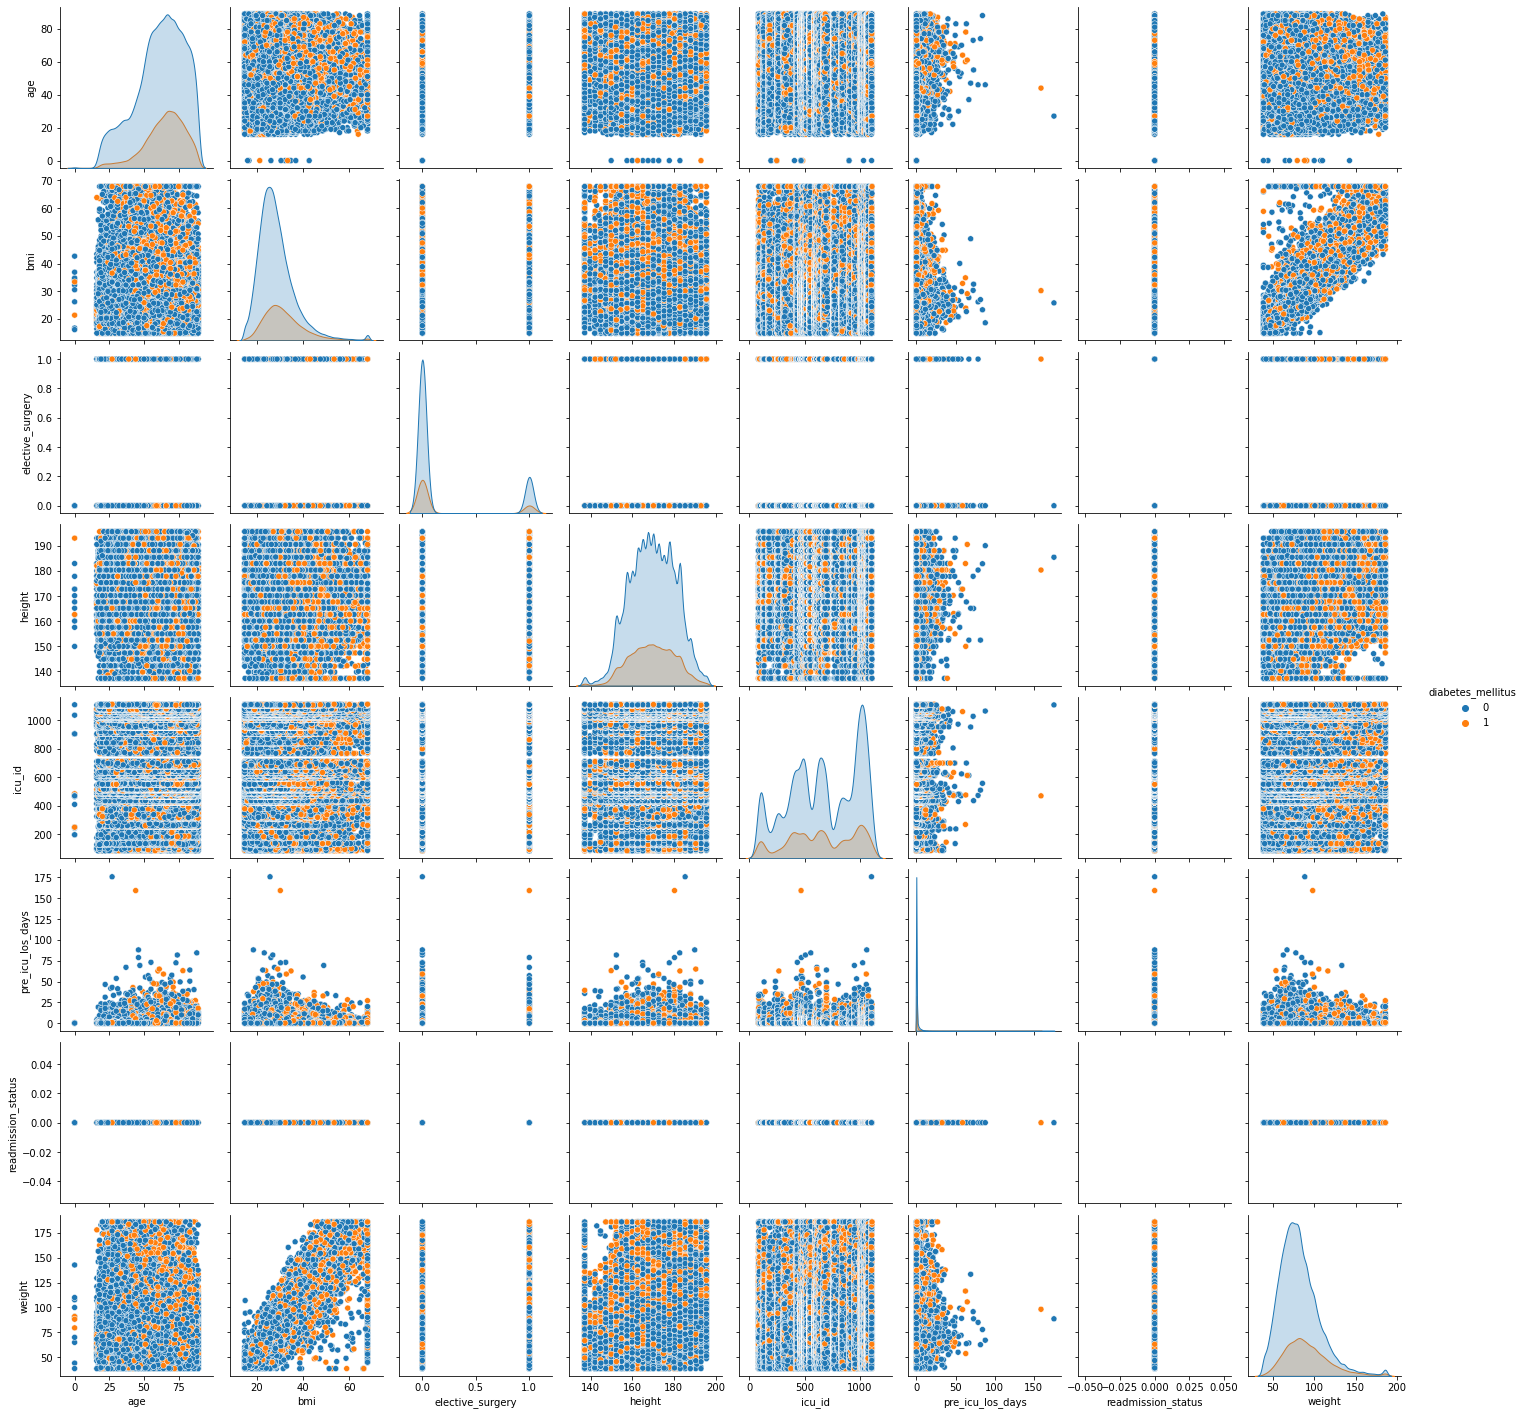

In [98]:
# pairplot for correlations between demographic features
sns.pairplot(train_data[np.append(demo_fea, 'diabetes_mellitus')], hue='diabetes_mellitus')

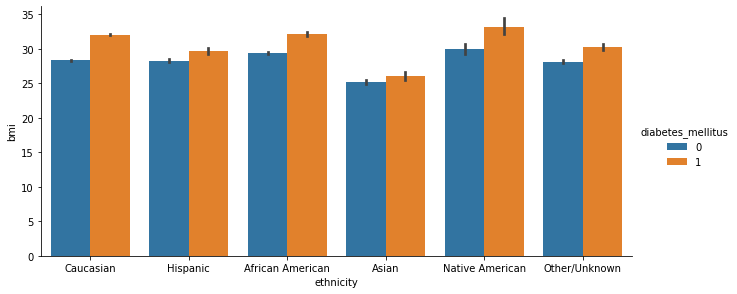

In [100]:
# pairplot for correlations between apache covariate features
sns.factorplot(x="ethnicity", y="bmi", 
               hue="diabetes_mellitus", data=train_data,
               kind="bar",height = 4, aspect = 2.2)

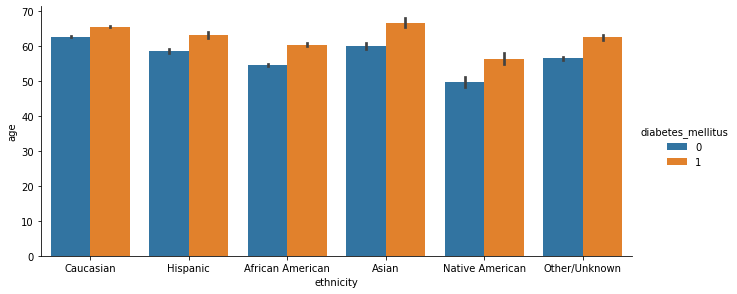

In [104]:
sns.factorplot(x="ethnicity", y="age", 
               hue="diabetes_mellitus", data=train_data,
               kind="bar",height = 4, aspect = 2.2)

There seems to be some interaction effect between BMI and ethnicity on diabetes.

### Data Integrity Check
#### Double check to make sure there is no data logging error

For example, when minimum and maximum values are flipped, or when bmi is not calculated correctly

In [76]:
min_max_feats=[f[:-4] for f in train_data.columns if f[-4:]=='_min']
# detect if any of the min-max values are input wrongly
train_count = dict()
test_count = dict()
for col in min_max_feats:
    train_data.loc[train_data[f'{col}_min'] > train_data[f'{col}_max'], [f'{col}_min', f'{col}_max']] = train_data.loc[train_data[f'{col}_min'] > train_data[f'{col}_max'], [f'{col}_max', f'{col}_min']].values
    test_data.loc[test_data[f'{col}_min'] > test_data[f'{col}_max'], [f'{col}_min', f'{col}_max']] = test_data.loc[test_data[f'{col}_min'] > test_data[f'{col}_max'], [f'{col}_max', f'{col}_min']].values
    if (np.any(train_data[f'{col}_min'] > train_data[f'{col}_max'])):
        train_count[col] = np.sum(train_data[f'{col}_min'] > train_data[f'{col}_max'])
    if (np.any(test_data[f'{col}_min'] > test_data[f'{col}_max'])):
        test_count[col] = np.sum(test_data[f'{col}_min'] > test_data[f'{col}_max'])

In [77]:
def fill_bmi(df):
    idx = np.argwhere(np.isnan(df.bmi.values))
    count = 0
    na_count = 0
    for i in idx:
        weight = df.weight.values[i]
        height = df.height.values[i]
        if np.isnan(weight) or np.isnan(height):
            na_count += 1
            continue
        else:
            df.at[i, 'bmi'] = weight/((height/100)**2)
            count += 1
        
    print('number of unfilled bmi value is: ', len(idx))
    print('number of either weight or height is missing: ', na_count)
    print('number of filled bmi is: ', count)
    
fill_bmi(train_data)
fill_bmi(test_data)

number of unfilled bmi value is:  4490
number of either weight or height is missing:  4490
number of filled bmi is:  0
number of unfilled bmi value is:  1015
number of either weight or height is missing:  1015
number of filled bmi is:  0


### Data Processing
#### Engineering new features

In [78]:
# Seperate age and bmi into groups
def age_group(x):
    if x<=50:
        return "0-50"
    elif x>50 and x<=65:
        return "50-65"
    elif x>65 and x<=75:
        return "65-75"
    elif x>75:
        return "75+"

def bmi_group(x):
    if x<= 18.5:
        return "underweight"
    elif x> 18.5 and x<= 25:
        return "normal"
    elif x> 25 and x<= 30:
        return "overweight"
    elif x> 30 and x<= 35:
        return "obese_class1"
    elif x> 35 and x<= 40:
        return "obese_class2"
    elif x> 40:
        return "obese_class3"

train_data['age_group'] = train_data['age'].apply(age_group)
train_data['bmi_group'] = train_data['bmi'].apply(bmi_group)
test_data['age_group'] = test_data['age'].apply(age_group)
test_data['bmi_group'] = test_data['bmi'].apply(bmi_group)

# add up the gcm scores
train_data['gcs_sum'] = train_data['gcs_eyes_apache']+train_data['gcs_motor_apache']+train_data['gcs_verbal_apache']
test_data['gcs_sum'] = test_data['gcs_eyes_apache']+test_data['gcs_motor_apache']+test_data['gcs_verbal_apache']


# function to obtain range of lab and vital features and compare between daily and hourly tests
lab_col = [c for c in train_data.columns if((c.startswith("h1")) | (c.startswith("d1")))]
lab_col_names = list(set(list(map(lambda i: i[ 3 : -4], lab_col))))
def lab_range(col_names, df):
    for v in col_names:
        df[v+"_d1_value_range"] = df[f"d1_{v}_max"].subtract(df[f"d1_{v}_min"])    
        df[v+"_h1_value_range"] = df[f"h1_{v}_max"].subtract(df[f"h1_{v}_min"])
        df[v+"_d1_zero_range"] = (df[v+"_d1_value_range"] == 0).astype(np.int8)
        df[v+"_h1_zero_range"] =(df[v+"_h1_value_range"] == 0).astype(np.int8)
        df[v+"_tot_change_value_range_normed"] = abs((df[v+"_h1_value_range"].div(df[v+"_h1_value_range"])))
        df[v+"_day_more_extreme"] = ((df[f"d1_{v}_max"]>df[f"h1_{v}_max"]) | (df[f"d1_{v}_min"]<df[f"h1_{v}_min"]))
        df[v+"_day_more_extreme"].fillna(False)    

lab_range(lab_col_names, train_data)
lab_range(lab_col_names, test_data)

# function to compare invasive and non-invasive measures
def invnoninv_comp(df):
    df['diasbp_indicator'] = ((df['d1_diasbp_invasive_max'] == df['d1_diasbp_max']) &
                              (df['d1_diasbp_noninvasive_max']==df['d1_diasbp_invasive_max'])|
                              (df['d1_diasbp_invasive_min'] == df['d1_diasbp_min']) & 
                              (df['d1_diasbp_noninvasive_min']==df['d1_diasbp_invasive_min'])|
                              (df['h1_diasbp_invasive_max'] == df['h1_diasbp_max']) & 
                              (df['h1_diasbp_noninvasive_max']==df['h1_diasbp_invasive_max'])|
                              (df['h1_diasbp_invasive_min'] == df['h1_diasbp_min']) & 
                              (df['h1_diasbp_noninvasive_min']==df['h1_diasbp_invasive_min'])).astype(np.int8)

    df['mbp_indicator'] = ((df['d1_mbp_invasive_max'] == df['d1_mbp_max']) & 
                              (df['d1_mbp_noninvasive_max']==df['d1_mbp_invasive_max'])|
                              (df['d1_mbp_invasive_min'] == df['d1_mbp_min']) & 
                              (df['d1_mbp_noninvasive_min']==df['d1_mbp_invasive_min'])|
                              (df['h1_mbp_invasive_max'] == df['h1_mbp_max']) & 
                              (df['h1_mbp_noninvasive_max']==df['h1_mbp_invasive_max'])|
                              (df['h1_mbp_invasive_min'] == df['h1_mbp_min']) & 
                              (df['h1_mbp_noninvasive_min']==df['h1_mbp_invasive_min'])).astype(np.int8)
    df['sysbp_indicator'] = ((df['d1_sysbp_invasive_max'] == df['d1_sysbp_max']) & 
                                (df['d1_sysbp_noninvasive_max']==df['d1_sysbp_invasive_max'])|
                                (df['d1_sysbp_invasive_min'] == df['d1_sysbp_min']) & 
                                (df['d1_sysbp_noninvasive_min']==df['d1_sysbp_invasive_min'])|
                                (df['h1_sysbp_invasive_max'] == df['h1_sysbp_max']) & 
                                (df['h1_sysbp_noninvasive_max']==df['h1_sysbp_invasive_max'])|
                                (df['h1_sysbp_invasive_min'] == df['h1_sysbp_min']) & 
                                (df['h1_sysbp_noninvasive_min']==df['h1_sysbp_invasive_min'])).astype(np.int8)

    df['d1_mbp_invnoninv_max_diff'] = df['d1_mbp_invasive_max'] - df['d1_mbp_noninvasive_max']
    df['h1_mbp_invnoninv_max_diff'] = df['h1_mbp_invasive_max'] - df['h1_mbp_noninvasive_max']
    df['d1_mbp_invnoninv_min_diff'] = df['d1_mbp_invasive_min'] - df['d1_mbp_noninvasive_min']
    df['h1_mbp_invnoninv_min_diff'] = df['h1_mbp_invasive_min'] - df['h1_mbp_noninvasive_min']
    df['d1_diasbp_invnoninv_max_diff'] = df['d1_diasbp_invasive_max'] - df['d1_diasbp_noninvasive_max']
    df['h1_diasbp_invnoninv_max_diff'] = df['h1_diasbp_invasive_max'] - df['h1_diasbp_noninvasive_max']
    df['d1_diasbp_invnoninv_min_diff'] = df['d1_diasbp_invasive_min'] - df['d1_diasbp_noninvasive_min']
    df['h1_diasbp_invnoninv_min_diff'] = df['h1_diasbp_invasive_min'] - df['h1_diasbp_noninvasive_min']
    df['d1_sysbp_invnoninv_max_diff'] = df['d1_sysbp_invasive_max'] - df['d1_sysbp_noninvasive_max']
    df['h1_sysbp_invnoninv_max_diff'] = df['h1_sysbp_invasive_max'] - df['h1_sysbp_noninvasive_max']
    df['d1_sysbp_invnoninv_min_diff'] = df['d1_sysbp_invasive_min'] - df['d1_sysbp_noninvasive_min']
    df['h1_sysbp_invnoninv_min_diff'] = df['h1_sysbp_invasive_min'] - df['h1_sysbp_noninvasive_min']

invnoninv_comp(train_data)
invnoninv_comp(test_data)

In [79]:
# Encode categorical values

categories = ['elective_surgery', 'icu_id', 'arf_apache', 'intubated_apache', 
        'ventilated_apache', 'cirrhosis','hepatic_failure', 'immunosuppression', 
        'leukemia', 'solid_tumor_with_metastasis', 'apache_3j_diagnosis',
        'apache_2_diagnosis', 'gcs_sum','hospital_admit_source', 
        'gcs_eyes_apache', 'gender', 'icu_stay_type', 'ethnicity', 'icu_admit_source', 
        'icu_type', 'age_group', 'bmi_group']
len(categories)

for col in categories:
    train_only = list(set(train_data[col].unique()) - set(test_data[col].unique()))
    test_only = list(set(test_data[col].unique()) - set(train_data[col].unique()))
    both = list(set(test_data[col].unique()).union(set(train_data[col].unique())))
    train_data.loc[train_data[col].isin(train_only), col] = np.nan
    test_data.loc[test_data[col].isin(test_only), col] = np.nan
    try:
        lbl = OrdinalEncoder(dtype='int')
        train_data[col] = lbl.fit_transform(train_data[col].astype('str').values.reshape(-1,1))
        test_data[col] = lbl.transform(test_data[col].astype('str').values.reshape(-1,1))
    except:
        lbl = OrdinalEncoder(dtype='int')
        train_data[col] = lbl.fit_transform(train_data[col].astype('str').fillna('-1').values.reshape(-1,1))
        test_data[col] = lbl.transform(test_data[col].astype('str').fillna('-1').values.reshape(-1,1))
    temp = pd.concat([train_data[[col]], test_data[[col]]], axis=0)
    temp_mapping = temp.groupby(col).size()/len(temp)
    temp['enc'] = temp[col].map(temp_mapping)
    temp['enc'] = stats.rankdata(temp['enc'])
    temp = temp.reset_index(drop=True)
    train_data[f'rank_frqenc_{col}'] = temp[['enc']].values[:train_data.shape[0]]
    test_data[f'rank_frqenc_{col}'] = temp[['enc']].values[train_data.shape[0]:]               
    test_data[col] = test_data[col].astype('category')
    train_data[col] = train_data[col].astype('category')

There are now 406 columns for train and test data.

#### Columns to drop

In [80]:
# calculate the percentage of non-NA data in each column of the train and test datasets
train_sparse = train_data.count()/train_data.shape[0]
test_sparse = test_data.count()/test_data.shape[0]

def drop_threshold(train: pd.DataFrame, test: pd.DataFrame, threshold: float) -> list:
    return list(set(train[train<threshold].index) and set(test[test<threshold].index))

sparse_column = drop_threshold(train_sparse, test_sparse, 0.4)
print('length of sparse column is: ', len(sparse_column),'\nThey are: ', sparse_column)

length of sparse column is:  125 
They are:  ['h1_mbp_invnoninv_min_diff', 'h1_pao2fio2ratio_min', 'diasbp_invasive_tot_change_value_range_normed', 'hematocrit_h1_value_range', 'h1_sysbp_invnoninv_max_diff', 'h1_mbp_invnoninv_max_diff', 'sysbp_invasive_tot_change_value_range_normed', 'h1_arterial_ph_min', 'h1_hemaglobin_min', 'h1_diasbp_invnoninv_max_diff', 'sodium_h1_value_range', 'h1_potassium_min', 'd1_arterial_pco2_min', 'h1_arterial_po2_max', 'lactate_h1_value_range', 'arterial_po2_d1_value_range', 'd1_lactate_min', 'mbp_invasive_d1_value_range', 'h1_bilirubin_min', 'h1_calcium_max', 'd1_mbp_invasive_max', 'h1_calcium_min', 'hco3_h1_value_range', 'hematocrit_tot_change_value_range_normed', 'sysbp_invasive_h1_value_range', 'h1_bun_min', 'h1_hemaglobin_max', 'paco2_apache', 'h1_bilirubin_max', 'arterial_po2_tot_change_value_range_normed', 'h1_sysbp_invasive_max', 'h1_platelets_max', 'd1_mbp_invasive_min', 'h1_bun_max', 'd1_arterial_ph_max', 'h1_arterial_pco2_max', 'hco3_tot_change_v

In [81]:
# data to drop
ID = ['encounter_id', 'hospital_id']
drop_col = list(set(sparse_column + ID))

In [82]:
print(len(drop_col))
train = train_data.drop(drop_col, axis=1)
test = test_data.drop(drop_col, axis=1)
train.shape, test.shape

127


((130157, 284), (10234, 284))

#### Prepare data for model training

In [83]:
lgb_data = lgb.Dataset(train, train_Y)

### LightGBM Bayesian Optimizer Tuning

In [84]:
from bayes_opt import BayesianOptimization as BO

warnings.filterwarnings('ignore')


def lgb_bayes(data):
    def lgb_eval(learning_rate, feature_fraction, max_depth, lambda_l1,
                 lambda_l2, scale_pos_weight, num_leaves, min_data_in_leaf):
        lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'bagging_fraction': 1.0,
            'bagging_freq': 0,
            'learning_rate': learning_rate,
            'feature_fraction': feature_fraction,
            'max_depth': int(max_depth),
            'lambda_l1': lambda_l1,
            'lambda_l2': lambda_l2,
            'scale_pos_weight': int(scale_pos_weight),
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf),
            'verbose': -1,
            'feature_pre_filter': False
        }

        cv_bst = lgb.cv(lgb_params, data, nfold=5, num_boost_round=10000, early_stopping_rounds=200,
                        return_cvbooster=True)

        return cv_bst['auc-mean'][-1]

    lgb_param_space = {
        'learning_rate': (0.001, 0.01),
        'feature_fraction': (0.4, 0.8),  # opt by optuna: 0.62
        'lambda_l1': (0, 10),  # opt by optuna: 0
        'lambda_l2': (0, 10),  # opt by optuna: 3.17
        'max_depth': (3, 6),
        'scale_pos_weight': (1, 10),
        'num_leaves': (15, 255),  # opt by optuna: 21
        'min_data_in_leaf': (10, 50)  # opt by optuna: 20
    }

    return lgb_eval, lgb_param_space


def run_bayes_opt(eval_func, param_space):
    """
    This function is to run Bayesian optimization.
    'init_points' is the number of initializations - random search.
    'n_iter' is the number of iterations after your random initializations.
    """

    bo = BO(eval_func, param_space)

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        bo.maximize(init_points=5,  # can increase if performance not good
                    n_iter=10,  # can increase if performance not good
                    acq='ucb',  # can try 'ei' or 'poi'
                    alpha=1e-6,
                    kappa=5#,  # can try 10 with acq='ucb'
                    #kappa_decay=0.99,  # can tune with acq='ucb'
                    #kappa_decay_delay=3,  # can increase if kappa decays too fast
                    #xi=0.1,  # can 0.001 with acq='ei' or acq='poi'
                    )
    return bo

In [ ]:
lgb_eval, lgb_param_space = lgb_bayes(lgb_data)
lgb_bo = run_bayes_opt(lgb_eval, lgb_param_space)
max_bo_params = lgb_bo.max['params']
print(max_bo_params)

In [ ]:
opt_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 10000,
        'learning_rate': max_bo_params['learning_rate'] / 2,
        'feature_fraction': max_bo_params['feature_fraction'],
        'max_depth': int(max_bo_params['max_depth']),
        'lambda_l1': max_bo_params['lambda_l1'],
        'lambda_l2': max_bo_params['lambda_l2'],
        'scale_pos_weight': int(max_bo_params['scale_pos_weight']),
        'min_data_in_leaf': int(max_bo_params['min_data_in_leaf']),
        'early_stopping_round': 300,
    }

print(opt_params)

In [ ]:
# retrain model with optimal parameters
bo_bst = lgb.cv(opt_params, lgb_data, nfold=5, num_boost_round=10000, early_stopping_rounds=200,
                return_cvbooster=True)

preds = bo_bst['cvbooster'].predict(xs_test, num_iteration=bo_bst['cvbooster'].best_iteration)
submission = pd.read_csv('../data/UnlabeledWiDS2021.csv', usecols=['encounter_id'])
submission['diabetes_mellitus'] = np.mean(preds, axis=0)
submission.to_csv("../data/submission.csv", header=True, index=False)